### Bibliotecas

In [61]:
import pandas as pd
import numpy as np
import scipy
from scipy.fftpack import fft
from scipy.stats import norm
import pywt
import aeon
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.model_selection import cross_val_score
import math
import sklearn
from sklearn import svm
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
#from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm

#SAX e DWT grindSearch
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


### Dados

In [62]:
try:
    train_data = pd.read_parquet('\DS\Parquet_Quali\Trace_TRAIN.parquet')
    test_data = pd.read_parquet('\DS\Parquet_Quali\Trace_TEST.parquet')
except FileNotFoundError:
    print("Ensure the Parquet files are in the correct path.")
    raise

In [63]:
X_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values

X_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values

### Função de transformação dos dados.

In [64]:
def sax_transform(series, w, a):
    paa = [series[i:i + w].mean() for i in range(0, len(series), w)]
    
    if np.std(paa) != 0:
        paa = (paa - np.mean(paa)) / np.std(paa)
    else:
        paa = paa - np.mean(paa)
    
    breakpoints = norm.ppf(np.linspace(0, 1, a+1)[1:-1])
    sax_symbols = np.array(range(a))
    sax_representation = sax_symbols[np.digitize(paa, breakpoints)]
    
    return sax_representation

def transform_data(X, num_features=5):
    a = int(X.shape[1] / num_features)
    w = int(X.shape[1] / num_features)  # Ajuste do tamanho da janela baseado no número de características desejado
    
    X_sax = np.array([sax_transform(row, w, a) for row in X])
    X_fft = np.abs(fft(X, axis=1))
    
    coeffs_cA, coeffs_cD = pywt.dwt(X, 'db4', axis=1)
    X_dwt = np.hstack((coeffs_cA, coeffs_cD))
    
    X_paa = np.column_stack([X[:, i:i+2].mean(axis=1) for i in range(0, X.shape[1], 2)])

    return {
        "TS": X,
        "FFT": X_fft,
        "DWT": X_dwt,
        "PAA": X_paa,
        "SAX": X_sax
    }

### Seleção do modelo extrator e modelo classificador

In [65]:
def select_model(option, random_state):
    if option == '1nn':
        return KNeighborsTimeSeriesClassifier(distance='euclidean', n_neighbors=1)
    elif option == '3nn':
        return KNeighborsTimeSeriesClassifier(distance='dtw', n_neighbors=3)
    elif option == 'svm':
        return svm.SVC(C=100, gamma=0.01, kernel='rbf', probability=True)
    elif option == 'gbc':
        return GradientBoostingClassifier(n_estimators=100, random_state=random_state)
    elif option == 'nb':
        return GaussianNB()
    elif option == 'xgb':
        return xgb.XGBClassifier(random_state=random_state)
    elif option == 'rd':
        return RidgeClassifier()
    else:
        return RandomForestClassifier(n_estimators=100,random_state=random_state)

### Treino do modelos extrator e classificador

In [66]:
def train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='1nn', random_state=42, cv=5):
    trained_models = {}  # Salvar modelos treinados para cada transformação
    
    X_train_transformed = transform_data(X_train)  # Transformar todo o conjunto de treino

    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, desc="Training Base Models"):
        model = select_model(base_option, random_state)
        scores = cross_val_score(model, X_trans, y_train, cv=cv)  # Calcula a acurácia em k-fold cross-validation
        accuracy = np.mean(scores) if len(scores) > 0 else 0.0  # Calcula a média das acurácias
        model._accuracy = accuracy  # Adiciona um atributo _accuracy ao modelo
        model.fit(X_trans, y_train)
        trained_models[rep] = model
        
    # Preparar dados para o meta-classificador
    meta_features = []
    weights = {}  # Dicionário para armazenar os pesos dos modelos base
    for rep, model in trained_models.items():
        weight = math.pow(model._accuracy, 4)  # Calcula o peso usando a acurácia elevada à quarta potência
        weights[rep] = weight
    
    for i in range(X_train.shape[0]):
        instance_sums = np.zeros((1, len(np.unique(y_train))))  # Inicializar a soma das probabilidades para esta instância
        for rep, model in trained_models.items():
            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))
            # Adicionar o peso da probabilidade prevista para cada classe à soma correspondente
            instance_sums += proba * weights[rep]
        # Normalizar as somas pelo somatório dos pesos
        instance_sums /= np.sum(list(weights.values()))
        meta_features.append(instance_sums.flatten())  # Estender a lista com as probabilidades normalizadas

    meta_features = np.array(meta_features)
    np.savetxt("meta-features-train.csv", meta_features, delimiter=",")
    
    # Treinar o meta-classificador
    meta_classifier = select_model(meta_option, random_state)
    meta_classifier.fit(meta_features, y_train)
    
    return trained_models, meta_classifier


### Predicao do meta-classificador

In [67]:
def predict_with_meta_classifier(X_test, trained_base_models, trained_meta_classifier, weights=None):
    predictions = []
    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste
    
    for i in tqdm(range(len(X_test)), ascii=True, desc="Testing Instances"):
        x_instance = X_test[i].reshape(1, -1)
        x_transformed = transform_data(x_instance)
        
        instance_sums = np.zeros((1, len(np.unique(y_train))))  # Inicializar a soma das probabilidades para esta instância
        for rep, model in trained_base_models.items():
            proba = model.predict_proba(x_transformed[rep][0].reshape(1, -1))  # Ajuste aqui para pegar o primeiro elemento
            # Adicionar o peso da probabilidade prevista para cada classe à soma correspondente
            instance_sums += proba * (weights[rep] if weights else 1)
        # Normalizar as somas pelo somatório dos pesos
        instance_sums /= np.sum(weights) if weights else len(trained_base_models)
        
        meta_feature = instance_sums.flatten().reshape(1, -1)
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões
        
        meta_features_test.append(meta_feature.flatten())  # Adicionar meta-recursos da instância atual à lista
    
    # Converter a lista de meta-recursos dos dados de teste em um array numpy
    meta_features_test = np.array(meta_features_test)

    # Salvar todos os meta-recursos dos dados de teste em um arquivo CSV
    np.savetxt("meta-features-test.csv", meta_features_test, delimiter=",")
    
    return predictions


### Testando um único modelo - Random Forest como extrator e SVM como meta-classificador

In [68]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='svm', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 100/100 [00:04<00:00, 21.60it/s]

Accuracy: 0.85


### Testando RidgeClassifier

In [69]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='rd', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 100/100 [00:00<00:00, 274.18it/s]

Accuracy: 0.85


### Testando um único modelo - SVM como extrator e meta-classificador

In [70]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='svm', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)
print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 100/100 [00:00<00:00, 298.21it/s]

Accuracy: 0.85


### Treino em loop de todas as opções de classificadores disponiveis no Select Model.

In [71]:
algos = ['1nn', '3nn', 'svm', 'nb', 'gbc', 'rd']
for algo in algos:
    
    print(f'Meta-classificador com modelo extrator {algo.upper()}')
    
    # Training
    try:
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option=algo, meta_option=algo)
        # Testing
        predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)
    
        test_accuracy_meta = np.mean(predictions_test_meta == y_test)
        print(f'Acurácia do teste usando o meta-classificador com modelo extrator {algo}: {test_accuracy_meta}')
    except Exception as e:
        print(f"Ocorreu um erro no teste com o {algo}: {e}")
    print("-------------------------------")
print('RF (10x)')
for i in range(10):
    print(f'RF: Random seed = {i}')
    try:
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='random_forest', random_state=i)
    
        # Testing
        predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)
    
        test_accuracy = np.mean(predictions_test_meta == y_test)
        print(f'Acurácia do teste usando seed {i}: {test_accuracy}')
    except Exception as e:
        print(f"Ocorreu um erro no teste com o RF (seed {i}): {e}")
    print("-------------------------------")

Meta-classificador com modelo extrator 1NN


Training Base Models: 100%|##########| 5/5 [00:00<00:00, 36.26it/s]


Ocorreu um erro no teste com o 1nn: 'KNeighborsTimeSeriesClassifier' object has no attribute '_accuracy'
-------------------------------
Meta-classificador com modelo extrator 5NN


Testing Instances: 100%|##########| 100/100 [00:05<00:00, 17.27it/s]


Acurácia do teste usando o meta-classificador com modelo extrator 5nn: 0.86
-------------------------------
Meta-classificador com modelo extrator SVM


Testing Instances: 100%|##########| 100/100 [00:00<00:00, 205.79it/s]


Acurácia do teste usando o meta-classificador com modelo extrator svm: 0.86
-------------------------------
Meta-classificador com modelo extrator NB


Testing Instances: 100%|##########| 100/100 [00:00<00:00, 202.52it/s]


Acurácia do teste usando o meta-classificador com modelo extrator nb: 0.85
-------------------------------
Meta-classificador com modelo extrator GBC


Testing Instances: 100%|##########| 100/100 [00:00<00:00, 104.79it/s]


Acurácia do teste usando o meta-classificador com modelo extrator gbc: 0.86
-------------------------------
Meta-classificador com modelo extrator RD


Training Base Models: 100%|##########| 5/5 [00:00<00:00, 42.21it/s]


Ocorreu um erro no teste com o rd: 'RidgeClassifier' object has no attribute 'predict_proba'
-------------------------------
RF (10x)
RF: Random seed = 0


Testing Instances: 100%|##########| 100/100 [00:05<00:00, 19.87it/s]


Acurácia do teste usando seed 0: 0.84
-------------------------------
RF: Random seed = 1


Testing Instances: 100%|##########| 100/100 [00:05<00:00, 17.91it/s]


Acurácia do teste usando seed 1: 0.86
-------------------------------
RF: Random seed = 2


Testing Instances:  22%|##2       | 22/100 [00:01<00:03, 21.44it/s]


KeyboardInterrupt: 

### Utilizando um classificador raso com os dados extraidos do meta-classificador contra os dados puros

In [72]:
#Teste utilizando o classificador SVM
caract = np.loadtxt("meta-features-train.csv", delimiter=",")
val = np.loadtxt("meta-features-test.csv", delimiter=",")

clf = svm.SVC(probability=True)
clf.fit(caract, y_train)
y_hat = clf.predict(val)
test_accuracy_meta = np.mean(y_hat == y_test)
print(f"accuracy: {test_accuracy_meta}")

accuracy: 0.84


In [73]:
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train)
y_hat_ = clf.predict(X_test)
test_accuracy_meta = np.mean(y_hat == y_test)
print(f"accuracy: {test_accuracy_meta}")

accuracy: 0.84


### Gráfico das diferenças de dados

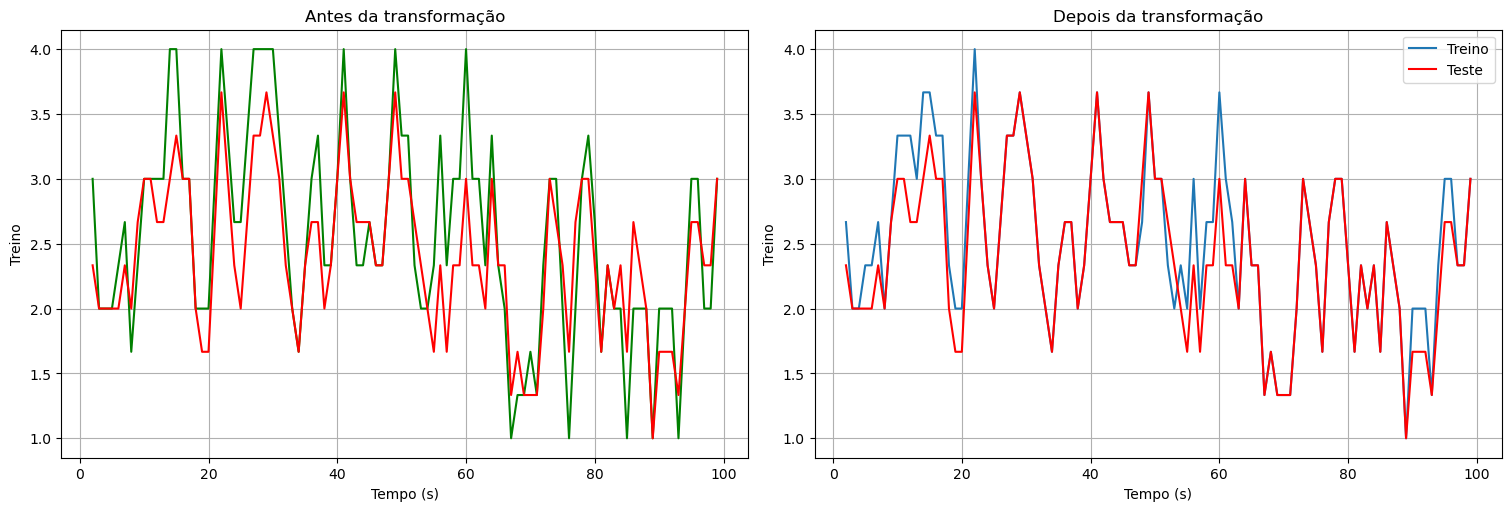

In [74]:
import matplotlib.pyplot as plt

y1 = y_hat  # depois da transformação
y2 = y_test  

z1 = y_hat_ #antes da transformação
z2 = y_test

#suavizar os dados do gráfico
window_size = 3
y1_smoothed = pd.Series(y1).rolling(window=window_size).mean()
y2_smoothed = pd.Series(y2).rolling(window=window_size).mean()
z1_smoothed = pd.Series(z1).rolling(window=window_size).mean()
z2_smoothed = pd.Series(z2).rolling(window=window_size).mean()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), layout='constrained')

# Conjunto de validação do classificador
axs[0].set_title('Antes da transformação')
axs[0].plot(z1_smoothed, label='Treino', color='green')
axs[0].plot(z2_smoothed, label='Teste', color='red')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Treino')
axs[0].grid(True)

# Conjunto de validação do meta-classificador
axs[1].set_title('Depois da transformação')
axs[1].plot(y1_smoothed, label='Treino')
axs[1].plot(y2_smoothed, label='Teste', color='red')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Treino')
axs[1].grid(True)

plt.legend()
plt.show()

